In [1]:
import mdtraj as md
import MDAnalysis as mda
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/ibpc/lumo/sritharan/.conda/envs/mdanalysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparer l'environnement

In [54]:
path_md = "/data/sritharan/Paris/Other_Project/Hanene/Water_Protein/AF/md/gromacs/"
name ="AF-Hanene" 
os.chdir(path_md)

In [29]:
all_md = ["M2"]
all_md


['M2']

# Les fonctions utilisé dans ce notebook
1) Inversion des coordonées des atomes sur l'axe Z (-1) pour le md.gro
2) Inversion des coordonées des atomes sur l'axe Z (-1) pour le traj.xtc
3) Recuperer les coordonnées sur l'axe Z pour les atom BB
4) Recuperer les coordonnées sur l'axe Z pour les atom PO4


In [13]:
def InverseZ_gro():
# Load the GRO file into memory using mdtraj
    traj = md.load("md.gro")
# Specify the axis along which to invert the coordinates (x=0, y=1, z=2)
    axis = 2
# Modify the coordinates along the specified axis
    traj.xyz[:,:,axis] *= -1
# Save the modified GRO file
    traj.save("inverted_file.gro")

In [14]:

def InverseZ_xtc():
    traj = md.load("md_OK_100.xtc", top="inverted_file.gro")
# Specify the axis along which to invert the coordinates (x=0, y=1, z=2)
    axis = 2
# Invert the coordinates along the specified axis
    traj.xyz[:, :, axis] *= -1
# Save the modified trajectory
    traj.save("inverted_trajectory.xtc")

In [15]:
def find_BB(lines):
    REF_ATOM = "BB"
    atoms_indexes=[]
    z_values=[]
    for line in lines:
        if REF_ATOM in line:
            temp=line.split()
            atoms_indexes.append(int(temp[2]))
            z_values.append(float(temp[5]))
        else:
            pass
    data=pd.DataFrame(data=atoms_indexes,columns=["atoms_indexes"])
    data["z(nm)"]=z_values
    mean_z=np.mean(z_values)
    max_z = np.max(z_values)
    min_z = np.min(z_values)
   
    return data,mean_z,max_z,min_z

In [16]:
def find_phosphate(lines):
    REF_ATOM = "PO4"
    atoms_indexes=[]
    z_values=[]
    for line in lines:
        if REF_ATOM in line:
            temp=line.split()
            atoms_indexes.append(int(temp[2]))
            z_values.append(float(temp[5]))
        else:
            pass
    data=pd.DataFrame(data=atoms_indexes,columns=["atoms_indexes"])
    data["z(nm)"]=z_values
    mean_z=np.mean(z_values)
    max_z = np.max(z_values)
    min_z = np.min(z_values)
    data["layer"]=["upper" if z > mean_z else "lower" for z in z_values]
   
    return data,mean_z,max_z,min_z

### un code pour determiner la moyenne sur l'axe

In [17]:
# Trouver les numero des BB
def recupere_atomBB(gro,debut,fin):
    file = open(gro)
    residue = []
    lines = file.readlines()
    file.close()
    for ligne in lines:
        col = ligne.split()
        if ligne.startswith("GRO"):
            continue
        else:
            try:
                if int(col[0][:3]) in range(debut, fin+1) and col[1] == "BB":
                    residue.append(col[2])
            except ValueError:
                continue
    for element in residue:
        print(element,end=" ")

In [26]:
# on rentre dans le dossier de simulations
all_md = os.listdir(path_md)


# 1)

In [31]:
for md in all_md:
    os.chdir(path_md)
    print(md)
    import mdtraj as md
    InverseZ_gro()
    InverseZ_xtc()

M2


In [190]:
# Premier graphique pour verifié si l'inversion a bien fonctionné

In [32]:
os.chdir(path_md)

In [33]:
file = open("inverted_file.gro")
#file = open("md.gro")
lines = file.readlines()
file.close()

In [34]:
phosphate_data,mean_z,max_z,min_z=find_phosphate(lines=lines)
BB_data,BB_mean_z,BB_max_z,BB_min_z=find_BB(lines=lines)

<Axes: xlabel='atoms_indexes', ylabel='z(nm)'>

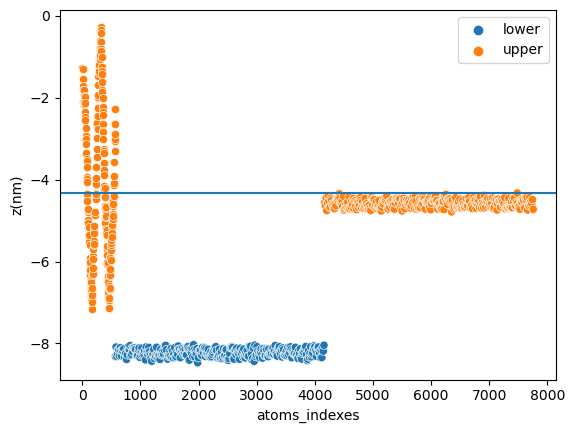

In [35]:
graph = sns.scatterplot(data=phosphate_data,x='atoms_indexes',y='z(nm)',hue='layer')
graph.axhline(max_z)
sns.scatterplot(data=BB_data,x='atoms_indexes',y='z(nm)')

# Avec gromacs 
1) Preparer les index de TM1 avec les BB des residues 600-635
2) Preparer les index de TM2 avec les BB des residues 715-750


In [38]:
os.chdir(path_md)
#all_md = os.listdir()
all_md = ["M2"]


In [43]:
# creation d'un dossier out_graph
for md in all_md:
    os.chdir(path_md+md)
    os.makedirs("out_graph2",exist_ok=True)
    os.system("cp inverted_file.gro "+ path_md + md + "/out_graph2")
    os.system("cp inverted_trajectory.xtc "+ path_md + md + "/out_graph2")
    os.system("cp md.tpr "+ path_md + md + "/out_graph2")


In [199]:
os.chdir(path_md)
all_md = os.listdir()
all_md

['E1']

In [45]:
#creation d'un index pour chaque md
for md in all_md:
    os.chdir(path_md + md+ "/out_graph2/")
    print(os.getcwd())
    with open("index-TM1-TM2.sh","w") as file:  
        file.write("/ibpc/lumo/sritharan/Téléchargements/Gromacs/gromacs-2021.5/build/bin/gmx make_ndx -f inverted_file.gro -o index-TM1-TM2.ndx <<EOF \n keep 1 \n q")
    file.close()
    !chmod +x index-TM1-TM2.sh
    os.system("./index-TM1-TM2.sh")
    !echo "[TM1]" >> index-TM1-TM2.ndx
    !echo "128 130 132 134 136 138 140 142 146 148 150 154 156 158 160 162 164 169 171 173 175 177 179 181 183 185 189 191 196 198 202 204 206 207 209 215" >> index-TM1-TM2.ndx
    !echo "[TM2]" >> index-TM1-TM2.ndx
    !echo "415 418 420 422 424 426 430 432 434 438 440 442 444 446 448 450 452 454 459 461 463 465 469 471 473 475 477 481 483 485 486 488 493 495 497 500" >> index-TM1-TM2.ndx
    !echo "" >> index-TM1-TM2.ndx

/data/sritharan/Paris/Other_Project/Hanene/Water_Protein/AF/md/gromacs/M2/out_graph2
Going to read 0 old index file(s)
Analysing residue names:
There are:   227    Protein residues
There are: 10950      Other residues
There are:   333        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 21603 atoms
  1 Protein             :   568 atoms
  2 Protein-H           :   568 atoms
  3 C-alpha             :     0 atoms
  4 Backbone            :     0 atoms
  5 MainChain           :     0 atoms
  6 MainChain+Cb        :     0 atoms
  7 MainChain+H         :     0 atoms
  8 SideChain           :   568 atoms
  9 SideChain-H         :   568 atoms
 10 Prot-Masses         :   568 atoms
 11 non-Protein         : 21035 atoms
 12 Other               : 20702 atoms
 13 PIPC                :  5760 atoms
 14 PIPE       

./index-TM1-TM2.sh: ligne 3: avertissement :« here-document » à la ligne 1 délimité par la fin du fichier (au lieu de « EOF »)
                     :-) GROMACS - gmx make_ndx, 2021.5 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl  

In [47]:
for md in all_md:
    os.chdir(path_md + md+ "/out_graph2/")
    !echo 1 | /ibpc/lumo/sritharan/Téléchargements/Gromacs/gromacs-2021.5/build/bin/gmx traj -f inverted_trajectory.xtc -s md.tpr -ox z_Tm1_lower_.xvg -n index-TM1-TM2.ndx -nox -noy -com > TM1_COM.log 2>&1
    !echo 2 |/ibpc/lumo/sritharan/Téléchargements/Gromacs/gromacs-2021.5/build/bin/gmx traj -f inverted_trajectory.xtc -s md.tpr -ox z_Tm2_lower_.xvg -n index-TM1-TM2.ndx -nox -noy -com > TM2_COM.log 2>&1


# Graphique

In [48]:
def open_file(file):
    x = []
    y = []
    with open(file) as f:
        for line in f:
            if line.startswith("#") or line.startswith("@"):
                pass
            else:
                cols = line.split()
                if len(cols) == 2:
                    x.append(float(cols[0]))
                    y.append(float(cols[1]))
    return x,y
    
def plot_z(z,folder,name):
    from scipy.signal import savgol_filter
    import statsmodels.api as sm
    
    x = []
    y = []
    a = []
    b = []
    c = []
    d = []
    x ,y= open_file("z_Tm2_lower_.xvg")
    a,b = open_file("z_Tm1_lower_.xvg")
    c,d = open_file("PO4_.xvg")
    
    # mean membrane on Z axe
    COM_z_PO4 = d
    mean_PO4 = np.mean(COM_z_PO4)
    
    
    #
    
    y2 = [y[i] - COM_z_PO4[i] for i in range(len(y))]
    b2 = [b[i] - COM_z_PO4[i] for i in range(len(b))]
    d2 = [d[i] - COM_z_PO4[i] for i in range(len(d))]

    # conversion de temps diviser par 1000
    myInt = 1000000
    x = [time / myInt for time in x]
    a = [time / myInt for time in a]
    c = [time / myInt for time in c]
    
    
    
# Appliquer le lissage Loess avec une fenêtre de 0.1 et un degré de 2
    TM2 = sm.nonparametric.lowess(y2, x ,frac=0.1, it=0, delta=0.0, is_sorted=True, missing='none', return_sorted=True)

    TM1 = sm.nonparametric.lowess(b2, a ,frac=0.1, it=0, delta=0.0, is_sorted=True, missing='none', return_sorted=True)

    PO4 = sm.nonparametric.lowess(d2, c ,frac=0.1, it=0, delta=0.0, is_sorted=True, missing='none', return_sorted=True)

    

    

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time (µs)')
    ax1.set_ylabel('z (nm)')

    plt.plot(TM1[:,0],TM1[:,1], c='orange', label='TM1')
    plt.plot(TM2[:,0],TM2[:,1], c='purple', label='TM2')
    plt.plot(PO4[:,0],PO4[:,1], c='darkblue', label='PO4')
    
    
    plt.scatter(x, y2,alpha=0.05,c = 'purple',s = 8)
    plt.scatter(a, b2,alpha=0.05,c = 'orange',s = 8)
    plt.scatter(c, d2,alpha=0.05,c = 'darkblue',s = 8)

    # Ajouter une ligne horizontale pour le centre de masse cible
    #ax1.axhline(z)
    plt.title(folder)
    # Ajouter une légende
    #leg = ax1.legend()

    # Enregistrer et afficher le graphique
    plt.savefig("Centre de masse " + folder + name + '.png')
    plt.show()



## Détermine les numero d'index des phosphate des lipides de la couche superieur

In [49]:
phosphate_data

,atoms_indexes,z(nm),layer
0,570,-8.321,lower
1,582,-8.088,lower
2,594,-8.316,lower
3,606,-8.247,lower
4,618,-8.150,lower
...,...,...,...
595,7710,-4.608,upper
596,7722,-4.517,upper
597,7734,-4.587,upper
598,7746,-4.486,upper


In [51]:
phosphate_data[300:]
upper_po4_index =  phosphate_data[300:]['atoms_indexes'].tolist()
print(' '.join(map(str, upper_po4_index)))

4170 4182 4194 4206 4218 4230 4242 4254 4266 4278 4290 4302 4314 4326 4338 4350 4362 4374 4386 4398 4410 4422 4434 4446 4458 4470 4482 4494 4506 4518 4530 4542 4554 4566 4578 4590 4602 4614 4626 4638 4650 4662 4674 4686 4698 4710 4722 4734 4746 4758 4770 4782 4794 4806 4818 4830 4842 4854 4866 4878 4890 4902 4914 4926 4938 4950 4962 4974 4986 4998 5010 5022 5034 5046 5058 5070 5082 5094 5106 5118 5130 5142 5154 5166 5178 5190 5202 5214 5226 5238 5250 5262 5274 5286 5298 5310 5322 5334 5346 5358 5370 5382 5394 5406 5418 5430 5442 5454 5466 5478 5490 5502 5514 5526 5538 5550 5562 5574 5586 5598 5610 5622 5634 5646 5658 5670 5682 5694 5706 5718 5730 5742 5754 5766 5778 5790 5802 5814 5826 5838 5850 5862 5874 5886 5898 5910 5922 5934 5946 5958 5970 5982 5994 6006 6018 6030 6042 6054 6066 6078 6090 6102 6114 6126 6138 6150 6162 6174 6186 6198 6210 6222 6234 6246 6258 6270 6282 6294 6306 6318 6330 6342 6354 6366 6378 6390 6402 6414 6426 6438 6450 6462 6474 6486 6498 6510 6522 6534 6546 6558 

In [55]:
for md in all_md:
    os.chdir(path_md + md+ "/out_graph2/")
    with open("index-PO4.sh","w") as file:  
        file.write("/ibpc/lumo/sritharan/Téléchargements/Gromacs/gromacs-2021.5/build/bin/gmx make_ndx -f inverted_file.gro -o index-PO4.ndx <<EOF \n keep 1 \n q")
    file.close()
    !chmod +x index-PO4.sh
    os.system("./index-PO4.sh")
    !echo "[PO4]" >> index-PO4.ndx
    !echo "4170 4182 4194 4206 4218 4230 4242 4254 4266 4278 4290 4302 4314 4326 4338 4350 4362 4374 4386 4398 4410 4422 4434 4446 4458 4470 4482 4494 4506 4518 4530 4542 4554 4566 4578 4590 4602 4614 4626 4638 4650 4662 4674 4686 4698 4710 4722 4734 4746 4758 4770 4782 4794 4806 4818 4830 4842 4854 4866 4878 4890 4902 4914 4926 4938 4950 4962 4974 4986 4998 5010 5022 5034 5046 5058 5070 5082 5094 5106 5118 5130 5142 5154 5166 5178 5190 5202 5214 5226 5238 5250 5262 5274 5286 5298 5310 5322 5334 5346 5358 5370 5382 5394 5406 5418 5430 5442 5454 5466 5478 5490 5502 5514 5526 5538 5550 5562 5574 5586 5598 5610 5622 5634 5646 5658 5670 5682 5694 5706 5718 5730 5742 5754 5766 5778 5790 5802 5814 5826 5838 5850 5862 5874 5886 5898 5910 5922 5934 5946 5958 5970 5982 5994 6006 6018 6030 6042 6054 6066 6078 6090 6102 6114 6126 6138 6150 6162 6174 6186 6198 6210 6222 6234 6246 6258 6270 6282 6294 6306 6318 6330 6342 6354 6366 6378 6390 6402 6414 6426 6438 6450 6462 6474 6486 6498 6510 6522 6534 6546 6558 6570 6582 6594 6606 6618 6630 6642 6654 6666 6678 6690 6702 6714 6726 6738 6750 6762 6774 6786 6798 6810 6822 6834 6846 6858 6870 6882 6894 6906 6918 6930 6942 6954 6966 6978 6990 7002 7014 7026 7038 7050 7062 7074 7086 7098 7110 7122 7134 7146 7158 7170 7182 7194 7206 7218 7230 7242 7254 7266 7278 7290 7302 7314 7326 7338 7350 7362 7374 7386 7398 7410 7422 7434 7446 7458 7470 7482 7494 7506 7518 7530 7542 7554 7566 7578 7590 7602 7614 7626 7638 7650 7662 7674 7686 7698 7710 7722 7734 7746 7758" >> index-PO4.ndx
    !echo "" >> index-PO4.ndx

Going to read 0 old index file(s)
Analysing residue names:
There are:   227    Protein residues
There are: 10950      Other residues
There are:   333        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 21603 atoms
  1 Protein             :   568 atoms
  2 Protein-H           :   568 atoms
  3 C-alpha             :     0 atoms
  4 Backbone            :     0 atoms
  5 MainChain           :     0 atoms
  6 MainChain+Cb        :     0 atoms
  7 MainChain+H         :     0 atoms
  8 SideChain           :   568 atoms
  9 SideChain-H         :   568 atoms
 10 Prot-Masses         :   568 atoms
 11 non-Protein         : 21035 atoms
 12 Other               : 20702 atoms
 13 PIPC                :  5760 atoms
 14 PIPE                :  1440 atoms
 15 W                   : 13502 atoms
 16 NA                  

./index-PO4.sh: ligne 3: avertissement :« here-document » à la ligne 1 délimité par la fin du fichier (au lieu de « EOF »)
                     :-) GROMACS - gmx make_ndx, 2021.5 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl      

In [56]:
for md in all_md:
    os.chdir(path_md + md+ "/out_graph2/")
    !echo 1 | /ibpc/lumo/sritharan/Téléchargements/Gromacs/gromacs-2021.5/build/bin/gmx traj -f inverted_trajectory.xtc -s md.tpr -ox PO4_.xvg -n index-PO4.ndx -nox -noy -com  > PO4_COM.log 2>&1 


In [141]:
## Graphique commande

M2


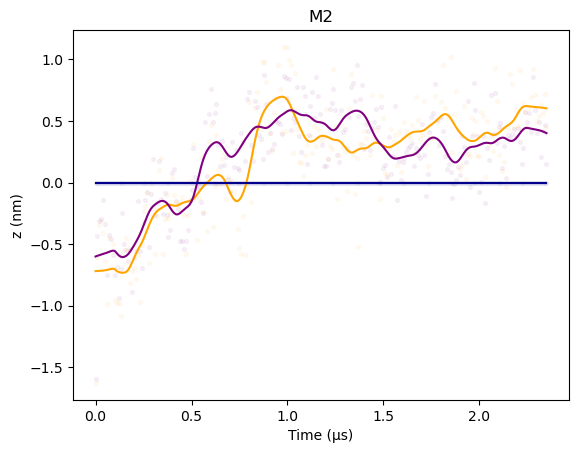

In [57]:
for md in all_md:
    os.chdir(path_md + md+ "/out_graph2/")
    print(md)
    plot_z(mean_z,md,name)


In [208]:
for md in all_md:
    os.chdir(path_md+md)
    !ls \#*\#
    !rm -f \#*\#  
    #Utiliser cette commande avec précaution , seulement si vous repere des fichier #..#

ls: impossible d'accéder à '#*#': Aucun fichier ou dossier de ce type


In [126]:
## Attention le path de resultat en fonction de dossier 

In [127]:
resultat = "/data/sritharan/Paris/Analyses_models/OUT-TM/ESM/" 
os.chdir(resultat)
#os.makedirs("out_TM",exist_ok=True)
!ls

'Centre de masse M10ESM-P1.png'  'Centre de masse M4ESM-P1.png'
'Centre de masse M10ESM-P2.png'  'Centre de masse M4ESM-P2.png'
'Centre de masse M10ESM-P3.png'  'Centre de masse M4ESM-P3.png'
'Centre de masse M10TR-P3.png'	 'Centre de masse M4TR-P3.png'
'Centre de masse M11ESM-P3.png'  'Centre de masse M5ESM-P1.png'
'Centre de masse M11TR-P3.png'	 'Centre de masse M5ESM-P2.png'
'Centre de masse M12ESM-P3.png'  'Centre de masse M6ESM-P1.png'
'Centre de masse M12TR-P3.png'	 'Centre de masse M6ESM-P2.png'
'Centre de masse M1ESM-P1.png'	 'Centre de masse M7ESM-P1.png'
'Centre de masse M1ESM-P2.png'	 'Centre de masse M7ESM-P2.png'
'Centre de masse M1ESM-P3.png'	 'Centre de masse M8ESM-P1.png'
'Centre de masse M1TR-P3.png'	 'Centre de masse M8ESM-P2.png'
'Centre de masse M2ESM-P1.png'	 'Centre de masse M9ESM-P1.png'
'Centre de masse M2ESM-P2.png'	 'Centre de masse M9ESM-P2.png'
'Centre de masse M3ESM-P1.png'	 'Centre de masse M9ESM-P3.png'
'Centre de masse M3ESM-P2.png'	 'Centre de masse M9T

In [128]:
os.chdir(path_md)
all_md = os.listdir()
all_md


['M12', 'M8', 'M6', 'M11']

In [129]:
# transfert des plot dans le dossier resultat
for md in all_md:
    os.chdir(path_md+md+"/out_graph2")
    !cp "Centre de masse "$md$name".png" $resultat

In [62]:
# verification des fichiers
os.chdir(resultat)
!ls


'Centre de masse M10ESM-P1.png'  'Centre de masse M4ESM-P2.png'
'Centre de masse M10ESM-P2.png'  'Centre de masse M4TR-P3.png'
'Centre de masse M10TR-P3.png'	 'Centre de masse M5ESM-P1.png'
'Centre de masse M11TR-P3.png'	 'Centre de masse M5ESM-P2.png'
'Centre de masse M12TR-P3.png'	 'Centre de masse M6ESM-P1.png'
'Centre de masse M1ESM-P1.png'	 'Centre de masse M6ESM-P2.png'
'Centre de masse M1ESM-P2.png'	 'Centre de masse M7ESM-P1.png'
'Centre de masse M1TR-P3.png'	 'Centre de masse M7ESM-P2.png'
'Centre de masse M2ESM-P1.png'	 'Centre de masse M8ESM-P1.png'
'Centre de masse M2ESM-P2.png'	 'Centre de masse M8ESM-P2.png'
'Centre de masse M3ESM-P1.png'	 'Centre de masse M9ESM-P1.png'
'Centre de masse M3ESM-P2.png'	 'Centre de masse M9ESM-P2.png'
'Centre de masse M4ESM-P1.png'	 'Centre de masse M9TR-P3.png'
